<center>

<h1>$\textbf{Quantum Circuit Born Machines}$</h1>

$\textit{Author : Antonis Kastellakis}$<br>

The Quantum Circuit Born Machine (QCBM) is a recently proposed parametrized quantum circuit model, that is used for unsupervised generative modeling. The implementation described here is founded on the approach outlined in reference [1].

In [ ]:
# Import required libraries
import random
import sys
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Import Qiskit libraries
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, execute, Aer, transpile
from qiskit.visualization import plot_histogram

# Import PySwarms library for optimization
import pyswarms as ps

In [ ]:
class BAS_QCBM(object):

    def __init__(self, num_rows, num_columns, num_layers, topology):
        """
        Initialize QCBM with BAS dataset parameters and topology.

        Parameters:
            num_rows (int): Number of rows in the BAS dataset.
            num_columns (int): Number of columns in the BAS dataset.
            num_layers (int): Number of layers in the QCBM.
            topology (str): Entangling layer topology ('chain', 'star', or 'all-to-all').
        """
        # The dimensions of the Bars and Stripes dataset.
        self.num_rows = num_rows
        self.num_columns = num_columns
        # This dataset is the Bars and Stripes (BAS) dataset.
        self.data = self.generate_BAS_dataset()
        # The target distribution in a dictionary form.
        self.target_distribution = self.generate_BAS_target_distribution()
        # The number of layer of the QCBM
        self.num_layers = num_layers
        # The topology of the entangling layer
        self.topology = self.qubit_topology(topology)
        # The number of paramaters the QCBM has
        self.num_params = self.count_params()
        # The QCBM
        self.qcbm = self.create_QCBM()

    def qubit_topology(self, topology):
        """
        Determine the qubit topology based on the given string.

        Parameters:
            topology (str): String representing the desired topology.

        Returns:
            int: Integer representing the qubit topology.
        Raises:
            ValueError: If the provided topology is not valid.
        """
        topology_mapping = {
            'chain': 0,
            'star': 1,
            'all-to-all': 2
        }

        if topology in topology_mapping:
            return topology_mapping[topology]
        else:
            raise ValueError(f"Invalid choice '{topology}'. This topology is not applicable.")



    def generate_BAS_dataset(self):
        """
        Generate Bars and Stripes (BAS) dataset.

        Returns:
            list: List of BAS patterns, where each pattern is represented as a list of 0s and 1s.
        """
        data = []

        # Generate horizontal stripes
        for h in itertools.product([0, 1], repeat=self.num_columns):
            pic = np.repeat([h], self.num_rows, 0)
            data.append(pic.ravel().tolist())

        # Generate vertical bars
        for h in itertools.product([0, 1], repeat=self.num_rows):
            pic = np.repeat([h], self.num_columns, 1)
            elem = pic.ravel().tolist()
            if elem not in data:
                data.append(pic.ravel().tolist())

        return data


    def generate_BAS_target_distribution(self):
        """
        Generate the target distribution for the Bars and Stripes (BAS) dataset.

        Returns:
            dict: Dictionary representing the target distribution with bitstrings as keys
                  and corresponding probabilities as values.
        """

        nBAS = (2**self.num_rows) + (2**self.num_columns) - 2

        distribution_dict = {}

        for image in self.data:
            bitstring = ""
            for qubit in image:
                bitstring += str(qubit)

            distribution_dict[bitstring] = 1/nBAS

        return distribution_dict


    def plot_BAS_target_distribution(self):
        """
        Plot the target distribution of the Bars and Stripes (BAS) dataset.
        """
        # Set width of bar
        barWidth = 0.25
        fig = plt.subplots(figsize =(10, 6))

        # Calculate the total number of patterns
        n = 2**(self.num_rows + self.num_columns)

        # Generate bitstrings for x-axis labels and corresponding target probabilities
        xticks = []
        target = []
        for i in range(n):
            num = "{0:04b}".format(i)
            xticks.append(num)
            bitstring = str(num)
            target.append(self.target_distribution.get(bitstring,0))

        # Set position of bar on X axis
        br1 = np.arange(n)

        # Make the plot
        plt.bar(br1, np.asarray(target), color ='b', width = barWidth,
        edgecolor ='grey')

        # Adding Xticks
        plt.title('Target Distribution')
        plt.xlabel('patterns')
        plt.ylabel('probabilities')

        # Adding Xticks
        plt.xticks([r for r in range(n)],xticks)
        plt.show()


    def visualize_non_BAS_images(self):
        """
        Visualize non-BAS images generated by the QCBM.

        This method generates and displays non-BAS images based on the QCBM's
        specified dataset dimensions. It visualizes these images in a 2x5 grid.

        Returns:
            None
        """
        #the BAS images
        dataset = self.data

        # Generate the non bas images
        non_bas_data = []

        num_of_BAS_patterns = (2**self.num_rows) + (2**self.num_columns) -2

        num_of_non_BAS_patterns = 2**(self.num_rows+self.num_columns) - num_of_BAS_patterns

        for i in range(16):
            num_str = "{0:04b}".format(i)
            num = [int(x) for x in num_str]
            if num not in dataset:
                non_bas_data.append(num)


        # Plot the non-BAS images
        fig = plt.figure(figsize=(10,4))

        fig.suptitle('non-BAS {0}x{1} images'.format(self.num_rows, self.num_columns),fontsize = 16)

        for idx in range(num_of_non_BAS_patterns):

            non_bas_img = np.asarray(non_bas_data[idx])
            # Adds a subplot at the 1st position
            fig.add_subplot(2, 5, idx+1)

            # showing image
            plt.imshow(np.reshape(non_bas_img, (2,2)), cmap = 'viridis', vmin = 0 , vmax = 1)
            plt.axis('off')


        plt.tight_layout()
        plt.show()


    def clipped_negative_log_likelihood(self, measured_distribution):
        """
        Compute the clipped negative log-likelihood between the target bitstring
        distribution and a measured bitstring distribution.

        Parameters:
            measured_distribution (dict): Dictionary representing the measured bitstring distribution.

        Returns:
            float: Clipped negative log-likelihood value.
        """
        epsilon = 0.0001
        value = 0.0

        target_keys = self.target_distribution.keys()
        measured_keys = measured_distribution.keys()
        all_keys = set(target_keys).union(measured_keys)

        for bitstring in all_keys:
            target_bitstring_value = self.target_distribution.get(bitstring, 0)
            measured_bitstring_value = measured_distribution.get(bitstring, 0)

            # Clip the measured probability to avoid log(0)
            clipped_probability = max(epsilon, measured_bitstring_value)

            # Compute clipped negative log-likelihood term
            value += target_bitstring_value * math.log(clipped_probability)

        # Return the negative of the computed value as it's a negative log-likelihood
        return -value


    def count_params(self):
        """
        Count the total number of parameters in the quantum circuit.

        Returns:
            int: Total number of parameters in the quantum circuit.
        """
        num_qubits = self.num_rows + self.num_columns
        num_layers = self.num_layers
        num_params = 0

        for layer in range(num_layers):

            # entangling layer
            if (layer % 2) == 1:
                if self.topology == 2:
                    # all-to-all connectivity
                    # The entangling layer has 6 parameters in a fully connected topology
                    num_params += 6
                else:
                    # star or chain connectivity
                    # The entangling layer has 3 parameters in a star or chain connected topology
                    num_params += 3

            # the single qubit rotation layer
            if (layer % 2) == 0:
                # The single qubit rotations layer has 3 gates, Rz Rx Rz, on each qubit.
                # With the execption of the first layer, since it starts at |0..0>, and thus
                # an Rz rotation has no effect.
                # If we have an odd number of layers, we can omitt
                # the Rz rotations on the last layer as well
                if (layer == 0) or (layer == num_layers-1):
                    num_params += num_qubits*2
                else:
                    num_params += num_qubits*3

        return num_params


    def create_QCBM(self):
        """
        Create a Quantum Circuit Born Machine (QCBM) with the specified topology and number of layers.

        Returns:
            QuantumCircuit: QCBM quantum circuit.
        """
        num_qubits = self.num_rows + self.num_columns

        qcbm = QuantumCircuit(num_qubits)

        num_params = self.num_params
        num_layers = self.num_layers

        # define your parameters
        theta = ParameterVector('θ', num_params)

        self.theta = theta

        # index of paramter in the parameter vector
        idx = 0;

        for layer in range(num_layers):

            # entangling layer
            if (layer % 2) == 1:
                if self.topology == 2:
                # all-to-all topology\n",
                    for qubit1 in range(num_qubits):
                        for qubit2 in range(qubit1+1,num_qubits):
                            qcbm.rxx(theta[idx],qubit1,qubit2)
                            idx += 1
                elif self.topology == 1:
                    # star topology
                    for qubit in range(1,num_qubits):
                        qcbm.rxx(theta[idx],0,qubit)
                        idx += 1
                else:
                # chain topology
                    for qubit in range(num_qubits-1):
                        qcbm.rxx(theta[idx],qubit,qubit+1)
                        idx += 1

                # add a barrier to distinguish the layers\n",
                if layer < num_layers-1:
                    qcbm.barrier()

            # the single qubit rotation layer
            if (layer % 2) == 0:
                if layer == 0 :
                    for qubit in range(num_qubits):
                        qcbm.rx(theta[idx],qubit)
                        idx +=1
                        qcbm.rz(theta[idx],qubit)
                        idx +=1
                elif layer == num_layers-1:
                    for qubit in range(num_qubits):
                        qcbm.rz(theta[idx],qubit)
                        idx +=1
                        qcbm.rx(theta[idx],qubit)
                        idx +=1
                else:
                    for qubit in range(num_qubits):
                        qcbm.rz(theta[idx],qubit)
                        idx +=1
                        qcbm.rx(theta[idx],qubit)
                        idx +=1
                        qcbm.rz(theta[idx],qubit)
                        idx +=1

                # add a barrier to distinguish the layers\n",
                if layer < num_layers-1:
                    qcbm.barrier()

        # measure all qubits
        qcbm.measure_all()

        return qcbm

    def visualize_circuit(self):
        """
        Visualize the Quantum Circuit Born Machine (QCBM) using Matplotlib.

        Note:
            This method assumes you are running it in a Jupyter Notebook environment.

        Raises:
            ImportError: If IPython.display is not available.
        """
        try:
            qc = self.qcbm
            display(qc.draw(output='mpl'))
        except ImportError:
            raise ImportError("IPython.display is not available. Unable to visualize the circuit.")

    def f(self, x):
        """
        Compute the loss for each particle in the swarm using the QCBM.

        Parameters:
            x (numpy.ndarray): Swarm positions of shape (n_particles, dimensions).

        Returns:
            numpy.ndarray: Computed loss for each particle of shape (n_particles,).
        """
        n_particles = x.shape[0]
        KL_divergence = [self.execute_QCBM(x[i]) for i in range(n_particles)]
        return np.array(KL_divergence)


    def execute_QCBM(self, params):
        """
        Execute the Quantum Circuit Born Machine (QCBM) for a specific set of parameters.

        Parameters:
            params (numpy.ndarray): Array of shape (num_params,) representing QCBM parameters.

        Returns:
            float: Clipped negative log likelihood loss for the measured distribution.
        """
        # Execute the quantum circuit for a specific set of parameters
        qc = self.qcbm

        theta = self.theta

        bind_dict = {}

        for i in range(self.num_params):
            # Need to use the defined ParameterVector label.
            key = theta[i]
            bind_dict[key] = params[i]

        # Assigned parameter without modifying the original circuit
        qc_params = qc.assign_parameters(bind_dict)

        job = execute(qc_params,Aer.get_backend('qasm_simulator'), shots=1000)

        # We can get the result of the outcome as follows
        counts = job.result().get_counts(qc_params)

        # Create a dictionary for the measured distribution
        measured_distribution = {}
        measured_keys = counts.keys()

        for bitstring in measured_keys:
            measured_value = counts.get(bitstring)
            measured_distribution[bitstring] = measured_value/1000

        loss = self.clipped_negative_log_likelihood(measured_distribution)

        return loss

    def optimize_system_parameters(self, c1, c2, w, k):
        """
        Optimize the QCBM system parameters using Particle Swarm Optimization (PSO).

        Parameters:
            c1 (float): Cognitive parameter for PSO.
            c2 (float): Social parameter for PSO.
            w (float): Inertia weight for PSO.
            k (int): Number of particles per dimension.

        Returns:
            None
        """
        # Initialize swarm options
        options = {'c1': c1, 'c2': c2, 'w': w}

        # Set dimensions to match the QCBM parameters
        dimensions = self.num_params

        # Set parameter bounds
        max_bound = math.pi * np.ones(dimensions)
        min_bound = -max_bound
        bounds = (min_bound, max_bound)

        # Initialize PSO optimizer
        optimizer = ps.single.GlobalBestPSO(n_particles=k*dimensions, dimensions=dimensions, options=options, bounds=bounds)

        # Perform optimization
        cost, pos = optimizer.optimize(self.f, iters=100)

        # Store the optimized parameters and cost history
        self.optimal_thetas = pos
        self.cost_history = optimizer.cost_history

    def experiment_statistics(self, params):
        """
        Execute the quantum circuit for a specific set of parameters, calculate the qBAS score, and plot the measured distribution.

        Parameters:
            params (numpy.ndarray): Array of optimized parameters for the quantum circuit.

        Returns:
            None
        """
        # Assign parameters to the quantum circuit
        qc = self.qcbm
        theta = self.theta
        bind_dict = {theta[i]: params[i] for i in range(self.num_params)}
        # Assigned parameter without modifying the original circuit
        qc_params = qc.assign_parameters(bind_dict)

        # Execute the quantum circuit and obtain counts
        job = execute(qc_params,Aer.get_backend('qasm_simulator'), shots=1000)
        counts = job.result().get_counts(qc_params)

        # Calculate the qBAS score
        self.qBAS_score(counts)

        # Create a dictionary for the measured distribution
        measured_distribution = {}
        measured_keys = counts.keys()

        for bitstring in measured_keys:
            measured_value = counts.get(bitstring)
            measured_distribution[bitstring] = measured_value/1000

        self.simulated_distribution = measured_distribution

        # Plot the target and measured distributions
        barWidth = 0.25
        fig = plt.subplots(figsize =(12, 8))

        # set height of bar and xticks
        n = 2**(self.num_rows + self.num_columns)
        xticks = []
        target = []
        measured = []
        for i in range(n):
            num = "{0:04b}".format(i)
            xticks.append(num)
            bitstring = str(num)
            target.append(self.target_distribution.get(bitstring,0))
            measured.append(measured_distribution.get(bitstring,0))


        # Set position of bar on X axis
        br1 = np.arange(n)
        br2 = [x + barWidth for x in br1]

        # Make the plot
        plt.bar(br1, np.asarray(target), color ='b', width = barWidth,
        edgecolor ='grey', label ='target distribution')
        plt.bar(br2, np.asarray(measured), color ='r', width = barWidth,
        edgecolor ='grey', label ='measured distribution')

        # Adding Xticks
        plt.title('Distribution generated by QCBM')
        plt.xlabel('patterns')
        plt.ylabel('probability')

        # Adding Xticks
        plt.xticks([r + barWidth for r in range(n)],xticks)
        plt.legend()
        plt.show()


    def qBAS_score(self, measurements):
        """
        Calculate the qBAS score based on the measurements obtained from the quantum circuit.

        Parameters:
            measurements (dict): Dictionary representing the measured bitstring distribution.

        Returns:
            float: The calculated qBAS score.
        """
        # Get the target bitstring distribution
        target_dict = self.target_distribution

        # Calculate the total number of measurements performed
        Nreads = 1000

        # Calculate the number of BAS patterns measured
        NBAS = sum(measurements.get(bitstring, 0) for bitstring in target_dict.keys())

        # Calculate the precision of measurements
        p = NBAS / Nreads

        # Calculate the number of unique patterns in the dataset
        nBAS = (2 ** self.num_rows) + (2 ** self.num_columns) - 2

        # Calculate the number of unique patterns that were measured
        dNreads = sum(1 for bitstring in target_dict.keys() if measurements.get(bitstring, 0) != 0)

        # Calculate the recall of measurements
        r = dNreads / nBAS

        # Calculate the qBAS score
        score = (2 * p * r) / (p + r)

        # Determine the topology type for display
        topology_type = ["chain", "star", "all-to-all"][self.topology]

        # Print the qBAS score
        print("The qBAS{}{} score for a circuit with {} topology and {} layers is {:.4f}."
              .format(self.num_rows, self.num_columns, topology_type, self.num_layers, score))

<h2>$\textbf{Experiments}$</h2>

<h3>$\textbf{QCBM with star topology and 2 layers}$</h3>

In [ ]:
# Define parameters as a dictionary
qcbm_params = {
    "num_rows": 2,
    "num_columns": 2,
    "num_layers": 2,
    "topology": 'star'
}

# PSO coefficients for particle swarm optimization
pso_params = {
    "c1": 1,
    "c2": 1,
    "w": 0.5,
    "k": 2
}

# Create an instance of BAS_QCBM using the provided parameters
qcbm_star1 = BAS_QCBM(**qcbm_params)

# Visualize the quantum circuit for the created QCBM instance
qcbm_star1.visualize_circuit()

In [ ]:
# Generate random parameters within the range of [-pi, pi]
qcbm_star1.execute_QCBM(np.random.uniform(-(math.pi), math.pi, qcbm_star1.num_params))

In [ ]:
# Optimize the system parameters using PSO with the provided coefficients
qcbm_star1.optimize_system_parameters(**pso_params)

In [ ]:
# Calculate the qBAS score, and plot the measured distribution
qcbm_star1.experiment_statistics(qcbm_star1.optimal_thetas)

<h3>$\textbf{QCBM with star topology and 4 layers}$</h3>

In [ ]:
# Define parameters as a dictionary
qcbm_params = {
    "num_rows": 2,
    "num_columns": 2,
    "num_layers": 4,
    "topology": 'star'
}

# Create an instance of BAS_QCBM using the provided parameters
qcbm_star2 = BAS_QCBM(**qcbm_params)

# Visualize the quantum circuit for the created QCBM instance
qcbm_star2.visualize_circuit()

In [ ]:
qcbm_star2.execute_QCBM(np.random.uniform(-(math.pi), math.pi, qcbm_star2.num_params))

In [ ]:
# Optimize the system parameters using PSO with the provided coefficients
qcbm_star2.optimize_system_parameters(**pso_params)

In [ ]:
# Calculate the qBAS score, and plot the measured distribution
qcbm_star2.experiment_statistics(qcbm_star2.optimal_thetas)

<h3>$\textbf{QCBM with Chain topology and 2 layers}$</h3>

In [ ]:
# Define parameters as a dictionary
qcbm_params = {
    "num_rows": 2,
    "num_columns": 2,
    "num_layers": 2,
    "topology": 'chain'
}

# Create an instance of BAS_QCBM using the provided parameters
qcbm_chain1 = BAS_QCBM(**qcbm_params)

# Visualize the quantum circuit for the created QCBM instance
qcbm_chain1.visualize_circuit()

In [ ]:
qcbm_chain1.execute_QCBM(np.random.uniform(-(math.pi), math.pi, qcbm_chain1.num_params))

In [ ]:
# Optimize the system parameters using PSO with the provided coefficients
qcbm_chain1.optimize_system_parameters(**pso_params)

In [ ]:
# Calculate the qBAS score, and plot the measured distribution
qcbm_chain1.experiment_statistics(qcbm_chain1.optimal_thetas)

<h3>$\textbf{QCBM with Chain topology and 4 layers}$</h3>

In [ ]:
# Define parameters as a dictionary
qcbm_params = {
    "num_rows": 2,
    "num_columns": 2,
    "num_layers": 2,
    "topology": 'chain'
}

# Create an instance of BAS_QCBM using the provided parameters
qcbm_chain2 = BAS_QCBM(**qcbm_params)

# Visualize the quantum circuit for the created QCBM instance
qcbm_chain2.visualize_circuit()

In [ ]:
qcbm_chain2.execute_QCBM(np.random.uniform(-(math.pi), math.pi, qcbm_chain2.num_params))

In [ ]:
# Optimize the system parameters using PSO with the provided coefficients
qcbm_chain2.optimize_system_parameters(**pso_params)

In [ ]:
# Calculate the qBAS score, and plot the measured distribution
qcbm_chain2.experiment_statistics(qcbm_chain2.optimal_thetas)

<h3>$\textbf{QCBM with Αll-Τo-Αll topology and 2 layers}$</h3>

In [ ]:
# Define parameters as a dictionary
qcbm_params = {
    "num_rows": 2,
    "num_columns": 2,
    "num_layers": 2,
    "topology": 'all-to-all'
}

# Create an instance of BAS_QCBM using the provided parameters
qcbm_all_to_all1 = BAS_QCBM(**qcbm_params)

# Visualize the quantum circuit for the created QCBM instance
qcbm_all_to_all1.visualize_circuit()


In [ ]:
qcbm_all_to_all1.execute_QCBM(np.random.uniform(-(math.pi), math.pi, qcbm_all_to_all1.num_params))

In [ ]:
# Optimize the system parameters using PSO with the provided coefficients
qcbm_all_to_all1.optimize_system_parameters(**pso_params)

In [ ]:
# Calculate the qBAS score, and plot the measured distribution
qcbm_all_to_all1.experiment_statistics(qcbm_all_to_all1.optimal_thetas)

<h3>$\textbf{QCBM with Αll-Τo-Αll topology and 4 layers}$</h3>

In [ ]:
# Define parameters as a dictionary
qcbm_params = {
    "num_rows": 2,
    "num_columns": 2,
    "num_layers": 4,
    "topology": 'all-to-all'
}

# Create an instance of BAS_QCBM using the provided parameters
qcbm_all_to_all2 = BAS_QCBM(**qcbm_params)

# Visualize the quantum circuit for the created QCBM instance
qcbm_all_to_all2.visualize_circuit()


In [ ]:
qcbm_all_to_all2.execute_QCBM(np.random.uniform(-(math.pi), math.pi, qcbm_all_to_all2.num_params))

In [ ]:
# Optimize the system parameters using PSO with the provided coefficients
qcbm_all_to_all2.optimize_system_parameters(**pso_params)

In [ ]:
# Calculate the qBAS score, and plot the measured distribution
qcbm_all_to_all2.experiment_statistics(qcbm_all_to_all2.optimal_thetas)

In [ ]:
# Plot optimization process for all circuits and topologies
plt.figure()
plt.plot(qcbm_star1.cost_history, 'b', label='star,{0} layers'.format(qcbm_star1.num_layers))
plt.plot(qcbm_star2.cost_history, 'b--', label='star,{0} layers'.format(qcbm_star2.num_layers))
plt.plot(qcbm_chain1.cost_history, 'r', label='chain,{0} layers'.format(qcbm_chain1.num_layers))
plt.plot(qcbm_chain2.cost_history, 'r--', label='chain,{0} layers'.format(qcbm_chain2.num_layers))
plt.plot(qcbm_all_to_all1.cost_history, 'g', label='all-to-all,{0} layers'.format(qcbm_all_to_all1.num_layers))
plt.plot(qcbm_all_to_all2.cost_history, 'g--', label='all-to-all,{0} layers'.format(qcbm_all_to_all2.num_layers))
plt.legend()
plt.title('QCBM optimization process')
plt.ylabel('Clipped negative log-likelihood')
plt.xlabel('iterations')
plt.show()

<h2>$\textbf{Experiment on a real IBM quantum device}$</h2>

At the moment, quantum computers are not yet commercial. A few prototypes are being developed by some big companies, such are Google or IBM, and some elite universities around the world. IBM has launched since 2016 an online platform, the **IBM Quantum Experience**, that allows the public access to cloud-based quantum computing services. This includes access to a set of IBM's prototype quantum processors, six of which are freely available for the public.

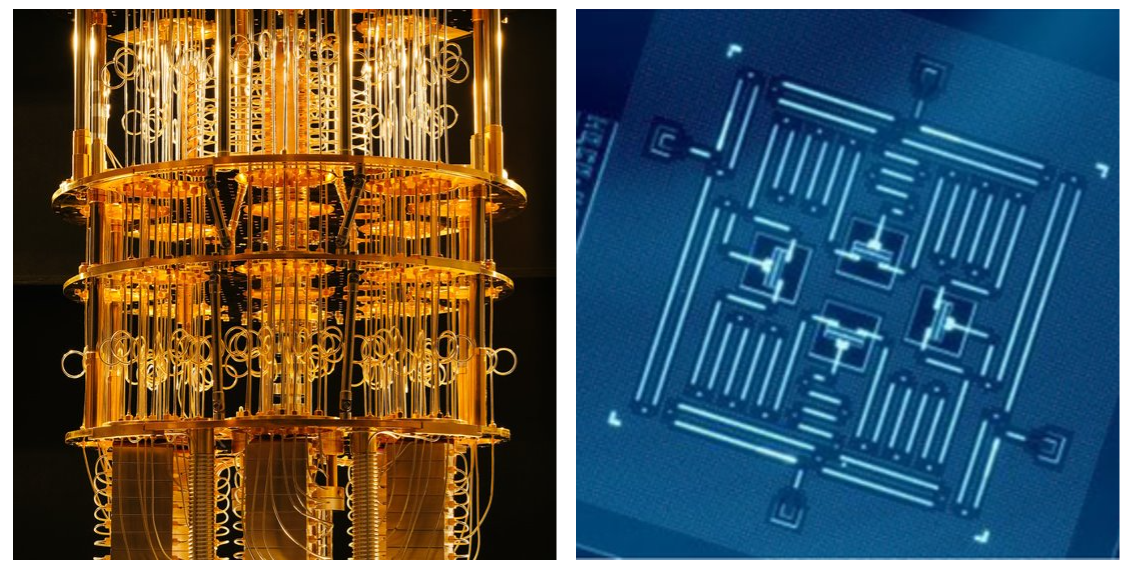



From the simulations we can clearly see that the circuit with the best recreation of the Bars and Stripes distribution, is the circuit with the all-to-all qubit connectivity in the entangling layer. Shallow quantum circuits are generally more preferable for NISQ quantum devices, as deeper circuits can significantly decrease the **fidelity** of the quantum states due to quantum decoherence.

Fidelity, in quantum information theory, is a measure that quantifies how close are two quantum states. Specifically, it describes the probability that one state will pass a test to identify as the other. In quantum computation, we use fidelity to express the quality of states that a quantum gate generate. Unfortunately, even the state of the art quantum gates do not have a fidelity of 1. Meaning that the more gates we apply, the more decoherence we add to the system and we risk a complete loss of information. Until fault-tolerant quantum computing is on our hands, one should take into account the fidelity of the gates that a specific quantum computer offers when designing the depth of the circuit.

Therefore, since longer circuits are subject to greater noise, we are focusing only on the shallow circuits. If the performance of the shallow circuit turns out bad, we can directly infer that the result for the longer circuit will also be bad. The ansatz that we choose to implement on a real IBM quantum processor in the cloud is the all-to-all topology, as it is the best performing among all three topologies. Note though that we only implement the optimal parameters on the IBM's device. The training is done on a classical computer.

Nonetheless, before running the circuit on a real device there is a few things we need to consider. First of all, some of the gates that we want to apply may not be available at the quantum device. Meaning that the gate has to be decomposed to a series of gates that would overall produce the the same effect. Secondly, we have to convert one set of gate operations to another set of gate operations, since the qubit connectivity, i.e. the geometry of the architecture, varies from one quantum computer to the another.

In [ ]:
# Import handy jupyter tools for viewing backend details and monitoring job status
from qiskit import IBMQ
import qiskit.tools.jupyter 
# You should see a floating tab "IBMQ Jobs" appear on the top left corner
%qiskit_job_watcher 
IBMQ.save_account("0f6330b426e330eb2a9fd742c8768cc8cdfdc119bf8e998acee00a685c03ed3c164ea1890f94e5d95511004b8e514940785be06ba4900ede0f445c12677abd80")

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

In [ ]:
# Get the least-busy backend at IQX, this step may take up to one minute
from qiskit.providers.ibmq import least_busy

device = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 4 and
                                   not b.configuration().simulator and b.status().operational==True))

device

In [ ]:
# Run on real quantum device and extract the statistics
# Execute the quantum circuit for the optimal set of parameters
# Calculate the qBAS score
# Plot the distribution that was measeaured after the optimization process

qc = qcbm_all_to_all1.qcbm

theta = qcbm_all_to_all1.theta
params = qcbm_all_to_all1.optimal_thetas

bind_dict = {}

for i in range(qcbm_all_to_all1.num_params):
    # Need to use the defined ParameterVector label.
    key = theta[i]
    bind_dict[key] = params[i]

# Assigned parameter without modifying the original circuit
qc_params = qc.assign_parameters(bind_dict)

optimized_circuit = qiskit.transpile(qc_params, device)
optimized_circuit.draw(output = 'mpl')

In [ ]:
# Run in real hardware
job = execute(optimized_circuit, device, shots=1000)

# Get the result of the outcome as follows
counts = job.result().get_counts(optimized_circuit)

# Calculate and plot the measured distribution
# Create a dictionary for the measured distribution
measured_distribution = {}
measured_keys = counts.keys()

for bitstring in measured_keys:
    measured_value = counts.get(bitstring)
    measured_distribution[bitstring] = measured_value/1000

# Set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(12, 8))

# Set height of bar and xticks
n = 2**(qcbm_all_to_all1.num_rows + qcbm_all_to_all1.num_columns)
xticks = []
target = []
measured = []
simulation = []

for i in range(n):
    num = "{0:04b}".format(i)
    xticks.append(num)
    bitstring = str(num)
    target.append(qcbm_all_to_all1.target_distribution.get(bitstring,0))
    measured.append(measured_distribution.get(bitstring,0))
    simulation.append(qcbm_all_to_all1.simulated_distribution.get(bitstring,0))


# Set position of bar on X axis
br1 = np.arange(n)
br2 = [x + barWidth for x in br1]
br3 = [x + 2*barWidth for x in br1]


# Make the plot
plt.bar(br1, np.asarray(target), color ='b', width = barWidth,
edgecolor ='grey', label ='target distribution')
plt.bar(br2, np.asarray(simulation), color ='r', width = barWidth,
edgecolor ='grey', label ='simulation')
plt.bar(br3, np.asarray(measured), color ='g', width = barWidth,
edgecolor ='grey', label ='experiment')


# Adding Xticks
plt.title('Distributions')
plt.xlabel('patterns')
plt.ylabel('probabilities')

# Adding Xticks
plt.xticks([r + barWidth for r in range(n)], xticks)
plt.legend()
plt.show()

After executing the circuit on the quantum computer it is obvious that noise is prevalent and messes with the results. The poor results compared to the simulation can be attributed to various reasons. As we said simulated circuits may use gates that are **not native** to the real device. Each of these gates are decomposed to a series of native gates that results to the **increase of the circuit depth**. The **fidelity of the gates** is not perfect, and thus, for each gate the accuracy drops! In addition to that, the theoretical model considers the quantum device a closed quantum system. However, the existing quantum devices are **susceptible to disturbance and noise from their environment**, which can lead to loss of information from a system into the environment. This phenomenon is amplified by the fact that the equipment that are used to control the qubits are imperfect, causing errors such as the **initialization error** or the **readout noise**.

It is important to note that this noisy results are expected and shouldn't be discouraging us from continuing to work with NISQ. Working with a quantum computer that allow us to implement the connectivity we need is essential to reducing the errors and noise. Previous implementations of this problem in an ion trap quantum computer has shown very promising results for the NISQ-era and the abilities of variational models.

## References

1. ["A generative modeling approach for benchmarking and training shallow quantum circuits", Marcello Benedetti, Delfina Garcia-Pintos, Oscar Perdomo, Vicente Leyton-Ortega, Yunseong Nam & Alejandro Perdomo-Ortiz.](https://www.nature.com/articles/s41534-019-0157-8)

